In [1]:
import tensorflow_datasets as tfds  
import tensorflow as tf  

tf.random.set_seed(0)  

train_steps = 1200  # 학습 과정에서의 총 step 수
eval_every = 200  # 몇 step마다 모델을 평가할지
batch_size = 32 # 한 번에 학습에 사용할 sample의 개수

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

2025-01-23 08:15:19.064135: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 08:15:19.078254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737620119.095012   51980 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737620119.100188   51980 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 08:15:19.117460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# MNIST 데이터셋 : 이미지를 픽셀값(0~255)으로 표현 -> 픽셀값을 0~1 범위로 정규화
train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)

In [3]:
train_ds = train_ds.repeat().shuffle(1024)
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [4]:
from flax import nnx
from functools import partial

class CNN(nnx.Module):  # 합성곱 신경망 : 작은 크기의 필터(커널)을 사용하여 이미지의 패턴을 학습

  def __init__(self, *, rngs: nnx.Rngs):   
    self.conv1 = nnx.Conv(1,32,kernel_size=(3, 3), rngs=rngs) #입력 이미지를 32개의 특징 맵으로 변환
    self.conv2 = nnx.Conv(32,64,kernel_size=(3, 3), rngs=rngs) #첫 번째 레이어의 출력을 64개의 특징 맵으로 변환
    self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
    self.linear1 = nnx.Linear(3136, 256, rngs=rngs) # 첫 번째 레이어 : 3136개의 입력을 받아 256개의 중간 출력 생성
    self.linear2 = nnx.Linear(256, 10, rngs=rngs) # 두 번째 레이어 : 256개의 중간 출력을 받아 10개의 클래스(0~9)로 분류

  def __call__(self, x):
    x = self.avg_pool(nnx.relu(self.conv1(x)))  #nnx.relu : ReLU 활성화 함수, 입력값의 음수를 0으로 변환하고 양수는 그대로 반환 -> 신경망에 비선형성을 추가 
    x = self.avg_pool(nnx.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten, 입력 : (32, 5, 5, 64)-> 출력 : (32, 1600) (5*5*64=1600)
    x = nnx.relu(self.linear1(x))
    x = self.linear2(x)
    return x  # (32, 10)

# Instantiate the model.
model = CNN(rngs=nnx.Rngs(0))
# Visualize 
nnx.display(model)

CNN(
  conv1=Conv(
    kernel_shape=(3, 3, 1, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 1, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=1,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7185701cff40>,
    bias_init=<function zeros at 0x71859bb7e4d0>,
    conv_general_dilated=<function conv_general_dilated at 0x71859e32c160>
  ),
  conv2=Conv(
    kernel_shape=(3, 3, 32, 64),
    kernel=Param(
      value=Array(shape=(3, 3, 32, 64), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    in_features=32,
    out_features=64,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_di

In [5]:
# Run the model 
import jax.numpy as jnp  
y = model(jnp.ones((1, 28, 28, 1)))
y

Array([[ 0.18405604,  0.5048598 ,  0.20095982,  0.48739713, -0.37915248,
        -0.55519223, -0.544814  , -0.04560174,  0.05879368,  0.13339695]],      dtype=float32)

In [6]:
##### 4. Create the optimizer and define some metrics #####
import optax # JAX 기반 최적화 라이브러리 -> 여기선 adamw를 쓸 것

learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(  #성능지표 정의 
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

# Optimizer의 설정 및 상태를 확인
nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=CNN(
    conv1=Conv(
      kernel_shape=(3, 3, 1, 32),
      kernel=Param(
        value=Array(shape=(3, 3, 1, 32), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(32,), dtype=float32)
      ),
      in_features=1,
      out_features=32,
      kernel_size=(3, 3),
      strides=1,
      padding='SAME',
      input_dilation=1,
      kernel_dilation=1,
      feature_group_count=1,
      use_bias=True,
      mask=None,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x7185701cff40>,
      bias_init=<function zeros at 0x71859bb7e4d0>,
      conv_general_dilated=<function conv_general_dilated at 0x71859e32c160>
    ),
    conv2=Conv(
      kernel_shape=(3, 3, 32, 64),
      kernel=Param(
        value=Array(shape=(3, 3, 32, 64), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(64

In [7]:
##### 5. Define training step functions #####
def loss_fn(model: CNN, batch):
    logits = model(batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']
    ).mean()  # 예측값(logits)과 실제 레이블(labels) 간의 교차 엔트로피 손실을 계산
    return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric,batch):
   """Train for a single step."""
   grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)  # loss_fn의 출력값과 기울기를 동시에 계산, has_aux=True : 손실 외의 추가 출력값(로짓)을 반환
   (loss, logits), grads = grad_fn(model, batch)
   metrics.update(loss=loss, logits=logits, labels=batch['label'])  # 성능 지표(metrics)를 업데이트
   optimizer.update(grads)  # model parameter 업데이트 

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label']) # In-place updates

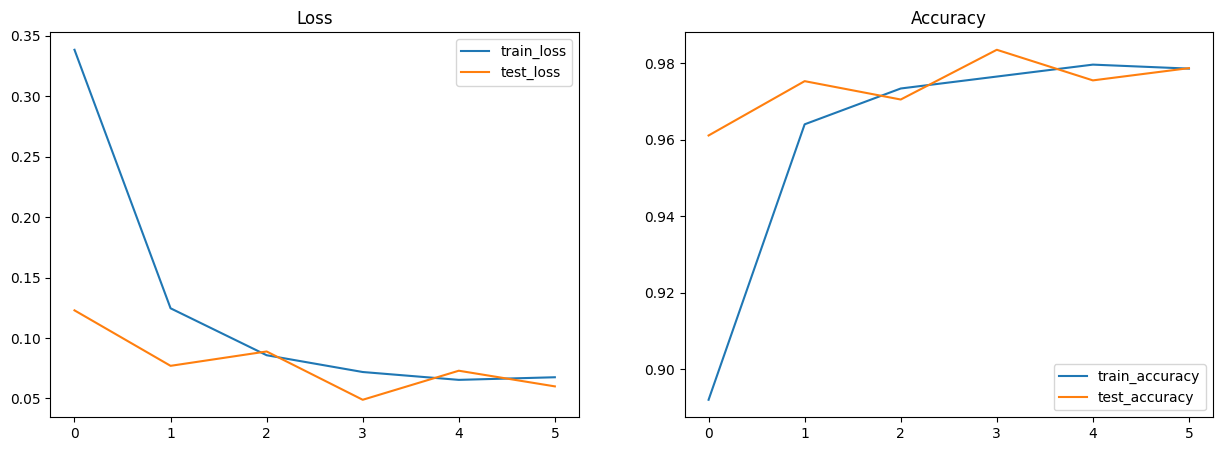

In [8]:
##### 6. Train and evaluate the model #####
from IPython.display import clear_output
import matplotlib.pyplot as plt

metrics_history = { # 성능 기록용 딕셔너리
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # one epoch 마다 
    # Log the training metrics.
    for metric, value in metrics.compute().items():  
      metrics_history[f'train_{metric}'].append(value)  
    metrics.reset()  

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  
    

    # 결과 시각화
    clear_output(wait=True)    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    for dataset in ('train', 'test'):
      ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
      ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
    ax1.legend()
    ax2.legend()
    plt.show()

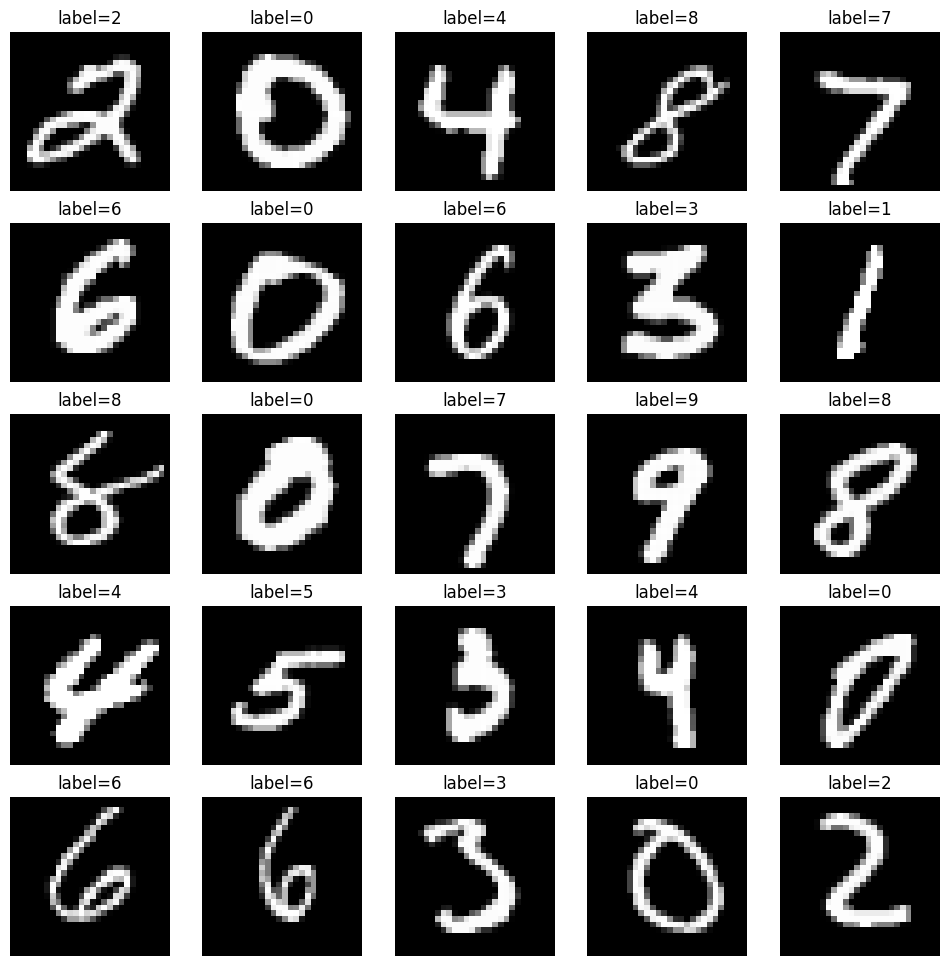

In [9]:
##### 7. Perform inference on the test set #####
model.eval() # evalution mode로 switch

@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')